## Pre-MCMC calculations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import astropy
import scipy.integrate as integrate
import pandas

In [2]:
# Importing constants 

Planck = astropy.cosmology.realizations.Planck18

T_CMB = Planck.Tcmb0  # Temperature of the CMB
H_0 = Planck.H0  # Current Hubble constant
Omega_m = Planck.Om0  # Matter density parameter
Omega_lambda = Planck.Ode0  # Dark energy density parameter
c = astropy.constants.c.to('km/s')  # Speed of light in km/s
sigma_T = astropy.constants.sigma_T.to('km2')  # Thomson scattering cross-section in km^2


# Setting parameters

z = 8.0  # Redshift of the quasar bubbles 
f_H = 0.21  # fraction of neutral hydrogen at z = 8

In [3]:
# Input Data

data = pandas.read_csv('Data/u_0.0pc_noise.csv')

Ang_deg = np.array(data['radius_y'])  # In arcmins
amp = np.array(data['amp_y']) * 1e-6  # Amplitude in K

In [4]:
# Defines the integrand that is to be integrated 
def integrand(z, Omega_m = Omega_m, Omega_lambda = Omega_lambda):
    return 1 / np.sqrt(Omega_m * (1 + z)**3 + Omega_lambda)

# Calculating other relevant distances

D_H = c / H_0  # Hubble distance

Integral = integrate.quad(integrand, 0, z)[0]  # Integrating from 0 to z
D_C = D_H * Integral  # Comoving distance
D_A = D_C / (1 + z)  # Angular diameter distance


# Function that converts the Angular radius into the actual radius

def AngToDist(Ang_deg, D_A = D_A):  # THE FUNCTION INPUTS ANGLES IN ARCMINS
     
    Ang_rad = Ang_deg * np.pi / (180 * 60)  # Convert arcmins to radians
    Distance = D_A * Ang_rad  # Convert angular distance to actual distance

    return Distance


In [16]:
# Calculating the actual radii of the bubbles and y

Radius = AngToDist(Ang_deg).value  # in Mpc

y = amp / T_CMB.value  

In [17]:
# Computing a z - list 

z_list = [z] * len(Radius)

----

## MCMC Sampling

In [18]:
# Defining the model using the Stromgren sphere approximation

def model(theta, z_list): 
    N_dot, t_Q, n_H = theta
    return (((3*N_dot*t_Q)/(4*np.pi*n_H))**(1/3)) * (1+z)**(-1)

In [19]:
# Setting up initial, lower and upper bounds for the parameters

N_dot_ini = 10**58  # in s^-1
N_dot_min =  10**56  # in s^-1
N_dot_max = 10**60  # in s^-1

t_Q_ini = 10**7  # in years
t_Q_ini = t_Q_ini * 3.156e7  # in s
t_Q_min = 10**5  # in years
t_Q_min = t_Q_min * 3.156e7  # in s 
t_Q_max = 10**9  # in years
t_Q_max = t_Q_max * 3.156e7  # in s

n_H_ini = 6e11  # in km^-3
n_H_min = 1e10  # in km^-3
n_H_max = 1e14  # in km^-3

In [20]:
# Calculating error in the diameter

Ang_err = np.array([0.1] * len(Ang_deg))  # Error in determining the angular diameter in arcmins
Radius_err = Ang_err * np.pi / (180 * 60) * D_A  # Convert angular error to actual diameter error

In [21]:
# Defining the log-likelihood function

def lnlike(theta, x, y, y_err):
    return -0.5 * np.sum(((y - model(theta, x)) / y_err) ** 2)

# Defining the log-prior function

def lnprior(theta):
    N_dot, t_Q, n_H = theta
    if N_dot < N_dot_min or t_Q < t_Q_min or n_H < n_H_min: # or N_dot > N_dot_max  or t_Q > t_Q_max:
        return -np.inf
    return 0.0

# Defining the log-posterior function

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


In [22]:
# Setting initial values for the parameters
initial = [N_dot_ini, t_Q_ini, n_H_ini]  

# Setting up the MCMC sampler
ndim = len(initial)
nwalkers = 5 * ndim    # Preferentially 3-5 times the number of dimensions (minimum 2 times the number of dimensions)
n_burn = 200
n_steps = 10000

# Initializing the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(z_list, Radius, Radius_err))

# Adding little variation to the initial positions
p0 = []
for i in range(nwalkers):
    pos = [N_dot_ini, t_Q_ini, n_H_ini]  # Start with the initial values
    pos[0] = pos[0] + 1e-4 * pos[0] * np.random.random(1)[0]  # Adding a small random variation to N_dot
    pos[1] = pos[1] + 1e-4 * pos[1] * np.random.random(1)[0]  # Adding a small random variation to t_Q
    pos[2] = pos[2] + 1e-4 * pos[2] * np.random.random(1)[0]  # Adding a small random variation to n_H
    p0.append(pos)


In [23]:
z_list

[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]

In [24]:
# Running the MCMC sampler

# Burn-in phase
print("Running burn-in phase...")
sampler.reset()
state = sampler.run_mcmc(p0, n_burn, progress=True)
sampler.reset()

# Main sampling phase
print("Running main sampling phase...")
pos, prob, state = sampler.run_mcmc(state, n_steps, progress=True)

# Extracting the samples
samples = sampler.get_chain(flat=True)      # Flatten the chain to get all samples in a single array


Running burn-in phase...


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 283.91it/s]


Running main sampling phase...


100%|██████████| 10000/10000 [00:31<00:00, 315.64it/s]


In [27]:
theta_max

array([6.78368347e+62, 4.05072593e+12, 5.38214647e+68])

In [25]:
theta_max = samples[np.argmax(sampler.flatlnprobability)]
print("N_dot:", theta_max[0], "; t_Q (in years):", theta_max[1]/3.156e7 )

N_dot: 6.783683465777551e+62 ; t_Q (in years): 128349.99763659072


In [26]:
# The Radii calculated from the model using the maximum likelihood parameters
model(theta_max, n_H).to('Mpc')

NameError: name 'n_H' is not defined

In [ ]:
# The radius_y values
Radius

<Quantity [10.64870116, 11.24029567, 11.53609292, 11.53609292, 11.83189018,
           12.42348469, 12.71928194, 13.0150792 ] Mpc>

In [ ]:
sampler.acceptance_fraction

array([0.1456, 0.1685, 0.1333, 0.1364, 0.1653, 0.21  , 0.1461, 0.1265,
       0.1859, 0.1523])

In [ ]:
# Sorting the n_H and Radius arrays based on n_H for better visualization

order = np.argsort(n_H)
n_H_ordered = n_H[order]
Radius_ordered = Radius[order]

model_ordered = model(theta_max, n_H_ordered).to('Mpc')

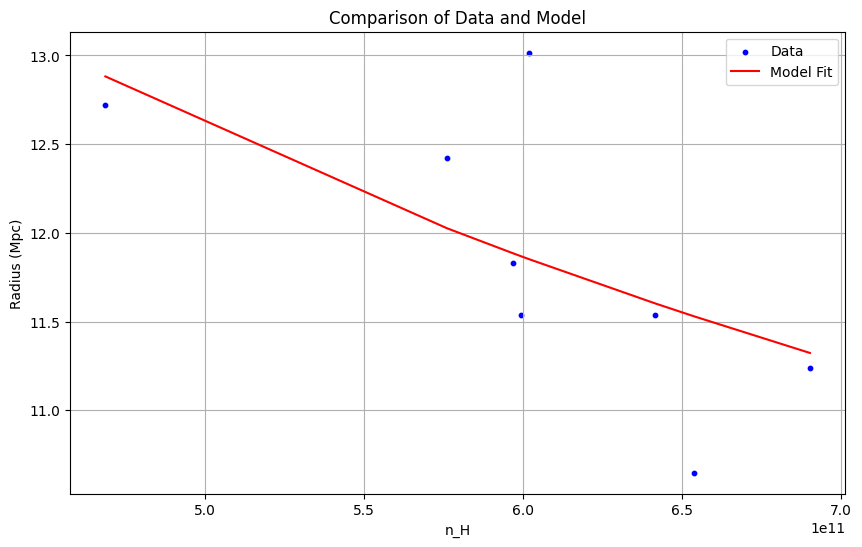

In [ ]:
# Plotting the results 

plt.figure(figsize=(10, 6))
plt.scatter(n_H, Radius, label='Data', color='blue', s=10)
plt.plot(n_H_ordered, model(theta_max, n_H_ordered).to('Mpc'), label='Model Fit', color='red')
plt.xlabel('n_H')
plt.ylabel('Radius (Mpc)')
plt.title('Comparison of Data and Model')
plt.legend()
plt.grid()
plt.show()


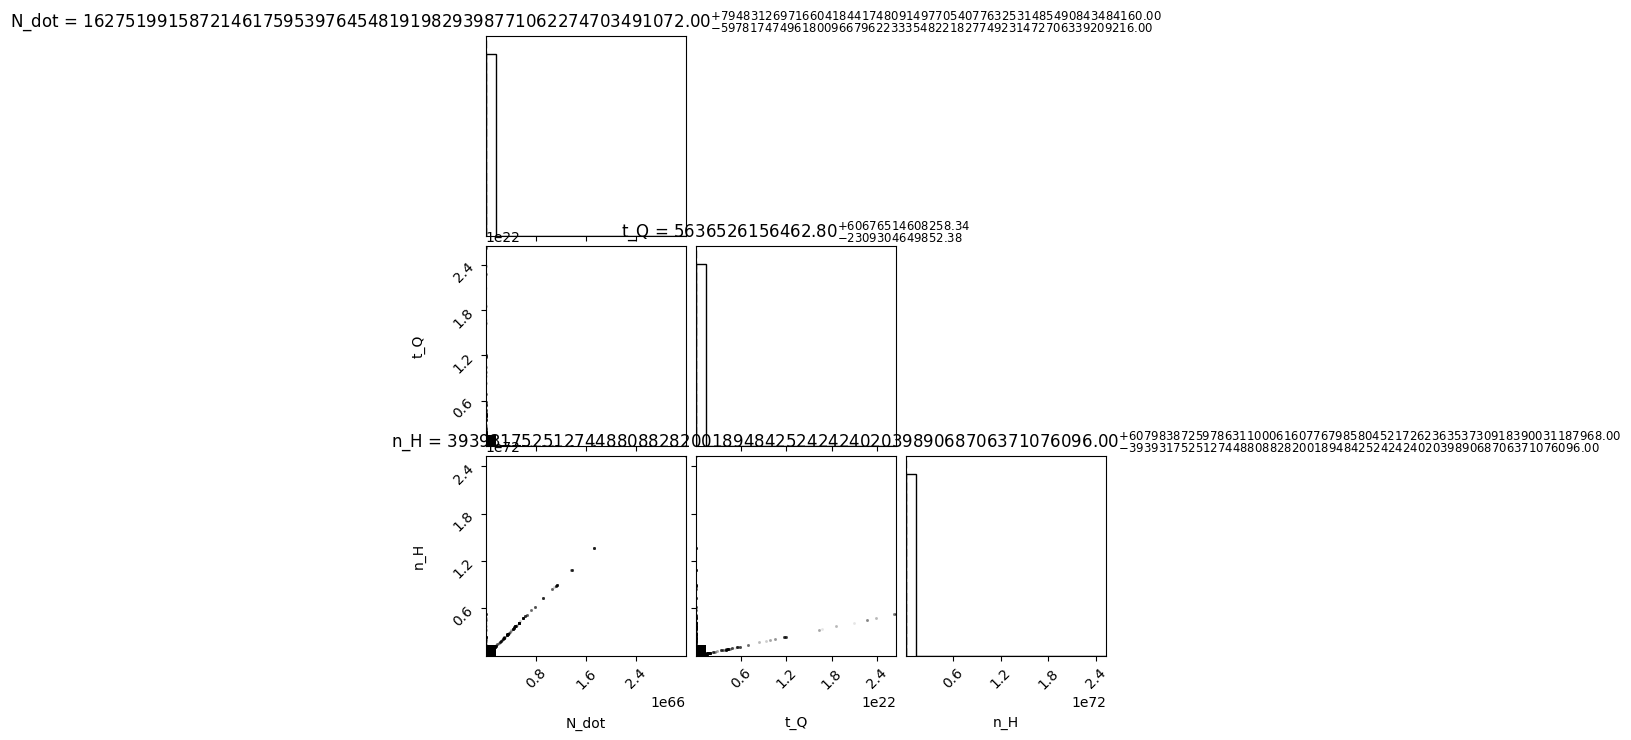

In [28]:
# Plotting a corner plot of the samples along with the quantiles

fig = corner.corner(samples, labels=["N_dot", "t_Q", "n_H"],  quantiles=[0.16, 0.5, 0.84], show_titles=True, plot_datapoints=True)

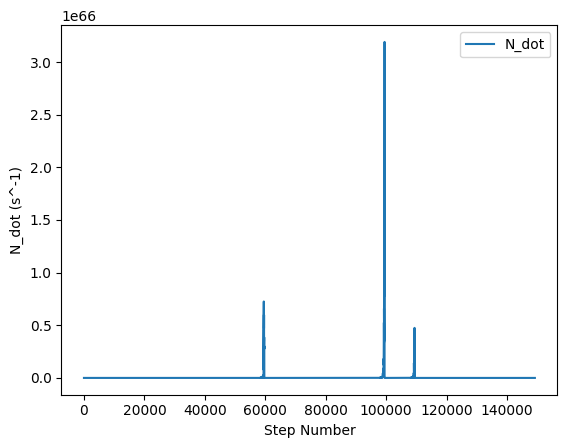

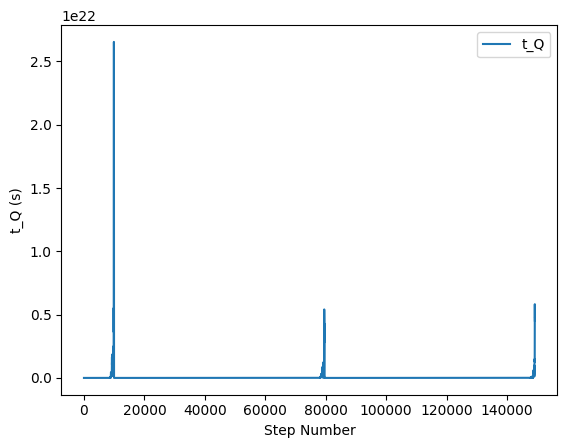

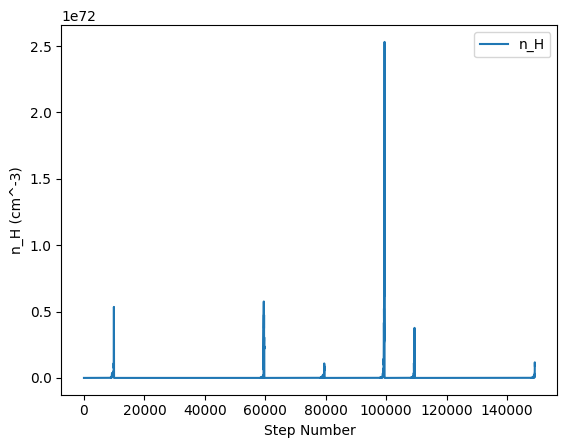

In [29]:
# Plotting the variation with time of the MCMC walkers

chains = sampler.chain[:, 50:, :].reshape((-1, ndim))

plt.plot(np.arange(len(chains[:, 0])), chains[:, 0], label='N_dot')
plt.xlabel('Step Number')
plt.ylabel('N_dot (s^-1)')
plt.legend()
plt.show()

plt.plot(np.arange(len(chains[:, 1])), chains[:, 1], label='t_Q')
plt.xlabel('Step Number')
plt.ylabel('t_Q (s)')
plt.legend()
plt.show()
plt.show()

plt.plot(np.arange(len(chains[:, 2])), chains[:, 2], label='n_H')
plt.xlabel('Step Number')
plt.ylabel('n_H (cm^-3)')
plt.legend()
plt.show()
plt.show()

Here I am performing the same MCMC sampling but with the input data, to compare the output with that of the previous scenario